In [1]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os, sys, pickle
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
import re

In [2]:
# Reproducibility
common.set_seed(156)

In [7]:
# Settings
train = True
HOME_DIR = "/home/fcbeylun/adv-bnn/"
HOME_DIR = "./"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

In [4]:
layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}

lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
outputs = 10
inputs = 1

In [8]:
class BBBLeNet(common.ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = common.layers.BBB_LRT_Linear
            BBBConv2d = common.layers.BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = common.layers.BBB_Linear
            BBBConv2d = common.layers.BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")

        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = common.layers.FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

class LeNet(nn.Module):

    def __init__(self, outputs, inputs, layer_type='lrt', activation_type='softplus'):
        '''
        Base LeNet model that matches the architecture of BayesianLeNet with randomly
        initialized weights
        '''
        super(LeNet, self).__init__()

        # initialization follows the BBBLeNet initialization, changing
        # BBBLinear and BBBConv2D layers to nn.Linear and nn.Conv2D

        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU

        self.conv1 = nn.Conv2d(inputs, 6, 5, padding=0, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120, bias=True)
        self.act3 = self.act()
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.act4 = self.act()
        self.fc3 = nn.Linear(84, outputs, bias=True)


    def sample(self, bbbnet):
        '''
        Takes in a BBBLeNet instance and copies the structure into a LeNet model.
        Replaces the BBBLinear and BBBConv2D that uses sampling in their forward steps
        with regular nn.Linear and nn.Conv2d layers whose weights are initialized by
        sampling the BBBLeNet model.
        '''
        ### store activation function used by BNN, only relu and softplus  currently supported
        self.act1 = bbbnet.act()
        self.act2 = bbbnet.act()
        self.act3 = bbbnet.act()
        self.act4 = bbbnet.act()

        ### maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=bbbnet.pool1.kernel_size, stride=bbbnet.pool1.stride)
        self.pool2 = nn.MaxPool2d(kernel_size=bbbnet.pool2.kernel_size, stride=bbbnet.pool2.stride)

        ### Create Convolution layers
        self.conv1 = nn.Conv2d(bbbnet.conv1.in_channels, bbbnet.conv1.out_channels, bbbnet.conv1.kernel_size,
                                stride=bbbnet.conv1.stride, padding=bbbnet.conv1.padding, dilation=bbbnet.conv1.dilation,
                                groups=bbbnet.conv1.groups)

        self.conv2 = nn.Conv2d(bbbnet.conv2.in_channels, bbbnet.conv2.out_channels, bbbnet.conv2.kernel_size,
                        stride=bbbnet.conv2.stride, padding=bbbnet.conv2.padding, dilation=bbbnet.conv2.dilation,
                        groups=bbbnet.conv2.groups)

        # follows the procedure for sampling in the forward methods of BBBConv and
        # BBBLinearforward to create a fixed set of weights to use for the sampled model

        conv1_W_mu = bbbnet.conv1.W_mu
        conv1_W_rho = bbbnet.conv1.W_rho
        conv1_W_eps = torch.empty(conv1_W_mu.size()).normal_(0,1)
        conv1_W_sigma = torch.log1p(torch.exp(conv1_W_rho))
        conv1_weight = conv1_W_mu + conv1_W_eps * conv1_W_sigma
        if bbbnet.conv1.use_bias:
            conv1_bias_mu = bbbnet.conv1.bias_mu
            conv1_bias_rho = bbbnet.conv1.bias_rho
            conv1_bias_eps = torch.empty(conv1_bias_mu.size()).normal_(0,1)
            conv1_bias_sigma = torch.log1p(torch.exp(conv1_bias_rho))
            conv1_bias = conv1_bias_mu + conv1_bias_eps * conv1_bias_sigma
        else:
            conv1_bias = None
        self.conv1.weight.data = conv1_weight.data
        self.conv1.bias.data = conv1_bias.data


        conv2_W_mu = bbbnet.conv2.W_mu
        conv2_W_rho = bbbnet.conv2.W_rho
        conv2_W_eps = torch.empty(conv2_W_mu.size()).normal_(0,1)
        conv2_W_sigma = torch.log1p(torch.exp(conv2_W_rho))
        conv2_weight = conv2_W_mu + conv2_W_eps * conv2_W_sigma
        if bbbnet.conv2.use_bias:
            conv2_bias_mu = bbbnet.conv2.bias_mu
            conv2_bias_rho = bbbnet.conv2.bias_rho
            conv2_bias_eps = torch.empty(conv2_bias_mu.size()).normal_(0,1)
            conv2_bias_sigma = torch.log1p(torch.exp(conv2_bias_rho))
            conv2_bias = conv2_bias_mu + conv2_bias_eps * conv2_bias_sigma
        else:
            conv2_bias = None
        self.conv2.weight.data = conv2_weight.data
        self.conv2.bias.data = conv2_bias.data

        ### Create Linear Layers
        self.fc1 = nn.Linear(bbbnet.fc1.in_features, bbbnet.fc1.out_features, bbbnet.fc1.use_bias)
        self.fc2 = nn.Linear(bbbnet.fc2.in_features, bbbnet.fc2.out_features, bbbnet.fc2.use_bias)
        self.fc3 = nn.Linear(bbbnet.fc3.in_features, bbbnet.fc3.out_features, bbbnet.fc3.use_bias)

        fc1_W_mu = bbbnet.fc1.W_mu
        fc1_W_rho = bbbnet.fc1.W_rho
        fc1_W_eps = torch.empty(fc1_W_mu.size()).normal_(0,1)
        fc1_W_sigma = torch.log1p(torch.exp(fc1_W_rho))
        fc1_weight = fc1_W_mu + fc1_W_eps * fc1_W_sigma
        if bbbnet.fc1.use_bias:
            fc1_bias_mu = bbbnet.fc1.bias_mu
            fc1_bias_rho = bbbnet.fc1.bias_rho
            fc1_bias_eps = torch.empty(fc1_bias_mu.size()).normal_(0,1)
            fc1_bias_sigma = torch.log1p(torch.exp(fc1_bias_rho))
            fc1_bias = fc1_bias_mu + fc1_bias_eps * fc1_bias_sigma
        else:
            fc1_bias = None
        self.fc1.weight.data = fc1_weight.data
        self.fc1.bias.data = fc1_bias.data

        fc2_W_mu = bbbnet.fc2.W_mu
        fc2_W_rho = bbbnet.fc2.W_rho
        fc2_W_eps = torch.empty(fc2_W_mu.size()).normal_(0,1)
        fc2_W_sigma = torch.log1p(torch.exp(fc2_W_rho))
        fc2_weight = fc2_W_mu + fc2_W_eps * fc2_W_sigma
        if bbbnet.fc2.use_bias:
            fc2_bias_mu = bbbnet.fc2.bias_mu
            fc2_bias_rho = bbbnet.fc2.bias_rho
            fc2_bias_eps = torch.empty(fc2_bias_mu.size()).normal_(0,1)
            fc2_bias_sigma = torch.log1p(torch.exp(fc2_bias_rho))
            fc2_bias = fc2_bias_mu + fc2_bias_eps * fc2_bias_sigma
        else:
            fc2_bias = None
        self.fc2.weight.data = fc2_weight.data
        self.fc2.bias.data = fc2_bias.data

        fc3_W_mu = bbbnet.fc3.W_mu
        fc3_W_rho = bbbnet.fc3.W_rho
        fc3_W_eps = torch.empty(fc3_W_mu.size()).normal_(0,1)
        fc3_W_sigma = torch.log1p(torch.exp(fc3_W_rho))
        fc3_weight = fc3_W_mu + fc3_W_eps * fc3_W_sigma
        if bbbnet.fc3.use_bias:
            fc3_bias_mu = bbbnet.fc3.bias_mu
            fc3_bias_rho = bbbnet.fc3.bias_rho
            fc3_bias_eps = torch.empty(fc3_bias_mu.size()).normal_(0,1)
            fc3_bias_sigma = torch.log1p(torch.exp(fc3_bias_rho))
            fc3_bias = fc3_bias_mu + fc3_bias_eps * fc3_bias_sigma
        else:
            fc3_bias = None
        self.fc3.weight.data = fc3_weight.data
        self.fc3.bias.data = fc3_bias.data



    def forward(self, x):
        '''
        Forward method follow the order of BayesianLeNet
        '''
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

def load_models(K = 50):
    # Load the models
    sampled_models = [LeNet(outputs, inputs, layer_type, activation_type).to(device) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load(HOME_DIR + '/models/model-cnn.pt')):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models


In [9]:
net = BBBLeNet(outputs, inputs, priors, layer_type, activation_type).to(device)
sampled_models = load_models(K = 50)
sampled_models = [m.to(device) for m in sampled_models]
softplus = torch.nn.Softplus()

Loaded 50 sample models


In [10]:

# Train dataset
train_dataset = torchvision.datasets.MNIST(HOME_DIR, train=True, download=True,
                       transform=transform_mnist)

# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False,
                                          generator=torch.Generator().manual_seed(156))

# Test dataset
test_dataset = torchvision.datasets.MNIST(HOME_DIR, train=False, download=True,
                       transform=transform_mnist)

# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                          generator=torch.Generator().manual_seed(156))


In [22]:
def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class

Adversarial example methods

In [11]:
def itcm(image, eps, model, steps, alpha, targets):
    with torch.no_grad():
        image_adv = torch.clone(image)
    for n in range(steps):
        image_adv.requires_grad = True
        image_adv.grad = None
        output   = model(image_adv)             #forward pass
        output   = torch.nn.LogSoftmax(dim=-1)(output)
        loss_fct = torch.nn.NLLLoss()
        loss     = loss_fct(output, targets)       #compute loss
        loss.backward()
        with torch.no_grad():
            x_grad         =  alpha * torch.sign(image_adv.grad)    
            adv_temp       = image_adv.data + x_grad  #add perturbation to img_variable which 
            #also contains perturbation from previous iterations
            total_grad     = torch.clamp(adv_temp - image, -eps, eps)
            image_adv.data = image - total_grad
    
    return image_adv

In [12]:
# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, new_images):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)
    
        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)

        # If we change the class, we fool the model
        fool += int(old_class != new_class)

    return fool/len(sampled_models)

In [19]:
images, targets  = next(iter(train_loader))

In [62]:
def generate_adv_image(EPS,target,images):
    # Collect noises (saliencies)
    # EPS = 0.18
    adv_images     = []
    how_many_fooled = []
    torch.set_printoptions(sci_mode=False)
    # target = torch.tensor([1])
    target = torch.tensor([target])
    for k in range(len(sampled_models)):
        # Forward pass
        # Compute loss w.r.t. an incorrect class
        # Note that we just have to ensure this class is different from targets
        # print("\r Processing " + str(k+1) + "/%s" % len(sampled_models), end="")
        images.grad = None
        images.requires_grad = True
        old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), targets])
        # Compute adversarial example
        new_images = itcm(images, EPS, sampled_models[k], 15, EPS*0.25, target)
        # Forward pass on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        if old_class != new_class:
            # How many models can this adv. example fool?
            how_many_fooled += [how_many_can_it_fool(sampled_models, new_images)]
            #saliencies += [(new_images-images).sign().detach().view(28, 28)]
            adv_images += [new_images.view(32, 32)]
    # print("\nFinished")
    return adv_images, how_many_fooled


In [35]:
images.shape

torch.Size([1, 1, 32, 32])

In [36]:
aa = generate_adv_image(0.18,9,images)

In [37]:
torch.zeros_like(aa[0][0]).shape

torch.Size([32, 32])

In [39]:
torch.stack(aa[0]).shape

torch.Size([34, 32, 32])

In [47]:
def combine_images(adv_images,success):
    # distributional saliency map
    combined_med  = torch.zeros_like(adv_images[0])
    combined_mean = torch.zeros_like(adv_images[0])

    adv_images = torch.stack(adv_images)
    # print(saliencies.shape)
    for i in range(28):
        for j in range(28):
            # choose median perturbation
            combined_med[i, j] = np.percentile(adv_images[:, i, j].detach().numpy(), 50)
            combined_mean[i, j] = adv_images[:, i, j].mean().item()
    combined_med  = combined_med.reshape(-1,32,32)
    combined_mean = combined_mean.reshape(-1,32,32)
    champ         = adv_images[success.index(max(success))].reshape(-1,32,32)
    return combined_med, combined_mean, champ

In [48]:
bb = combine_images(aa[0],aa[1])

In [49]:
med, mn, ch = bb

In [50]:
torch.vstack([med,med]).shape

torch.Size([2, 32, 32])

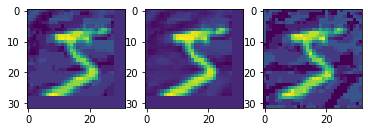

In [45]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(med.detach().numpy())
plt.subplot(1, 3, 2)
plt.imshow(mn.detach().numpy())
plt.subplot(1, 3, 3)
plt.imshow(ch.detach().numpy())
plt.show()

## Try Again

In [51]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
import pyro
import tqdm
import os, sys, pickle
import common
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
import re


# Settings
train = True
HOME_DIR = "/home/fcbeylun/adv-bnn/"
HOME_DIR = "./"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = "cpu"

# Reproducibility
common.set_seed(156)

layer_type = 'lrt'  # 'bbb' or 'lrt'
activation_type = 'softplus'  # 'softplus' or 'relu'
priors={
    'prior_mu': 0,
    'prior_sigma': 0.1,
    'posterior_mu_initial': (0, 0.1),  # (mean, std) normal_
    'posterior_rho_initial': (-5, 0.1),  # (mean, std) normal_
}

lr_start = 0.001
num_workers = 1
valid_size = 0.2
batch_size = 256
train_ens = 1
valid_ens = 1
beta_type = 0.1
transform_mnist = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])
outputs = 10
inputs = 1


class BBBLeNet(common.ModuleWrapper):
    '''The architecture of LeNet with Bayesian Layers'''

    def __init__(self, outputs, inputs, priors, layer_type='lrt', activation_type='softplus'):
        super(BBBLeNet, self).__init__()

        self.num_classes = outputs
        self.layer_type = layer_type
        self.priors = priors

        if layer_type=='lrt':
            BBBLinear = common.layers.BBB_LRT_Linear
            BBBConv2d = common.layers.BBB_LRT_Conv2d
        elif layer_type=='bbb':
            BBBLinear = common.layers.BBB_Linear
            BBBConv2d = common.layers.BBB_Conv2d
        else:
            raise ValueError("Undefined layer_type")

        if activation_type=='softplus':
            self.act = nn.Softplus
        elif activation_type=='relu':
            self.act = nn.ReLU
        else:
            raise ValueError("Only softplus or relu supported")

        self.conv1 = BBBConv2d(inputs, 6, 5, padding=0, bias=True, priors=self.priors)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = BBBConv2d(6, 16, 5, padding=0, bias=True, priors=self.priors)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = common.layers.FlattenLayer(5 * 5 * 16)
        self.fc1 = BBBLinear(5 * 5 * 16, 120, bias=True, priors=self.priors)
        self.act3 = self.act()

        self.fc2 = BBBLinear(120, 84, bias=True, priors=self.priors)
        self.act4 = self.act()

        self.fc3 = BBBLinear(84, outputs, bias=True, priors=self.priors)

class LeNet(nn.Module):

    def __init__(self, outputs, inputs, layer_type='lrt', activation_type='softplus'):
        '''
        Base LeNet model that matches the architecture of BayesianLeNet with randomly
        initialized weights
        '''
        super(LeNet, self).__init__()

        # initialization follows the BBBLeNet initialization, changing
        # BBBLinear and BBBConv2D layers to nn.Linear and nn.Conv2D

        if activation_type == 'softplus':
            self.act = nn.Softplus
        elif activation_type == 'relu':
            self.act = nn.ReLU

        self.conv1 = nn.Conv2d(inputs, 6, 5, padding=0, bias=True)
        self.act1 = self.act()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0, bias=True)
        self.act2 = self.act()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5 * 5 * 16, 120, bias=True)
        self.act3 = self.act()
        self.fc2 = nn.Linear(120, 84, bias=True)
        self.act4 = self.act()
        self.fc3 = nn.Linear(84, outputs, bias=True)


    def sample(self, bbbnet):
        '''
        Takes in a BBBLeNet instance and copies the structure into a LeNet model.
        Replaces the BBBLinear and BBBConv2D that uses sampling in their forward steps
        with regular nn.Linear and nn.Conv2d layers whose weights are initialized by
        sampling the BBBLeNet model.
        '''
        ### store activation function used by BNN, only relu and softplus  currently supported
        self.act1 = bbbnet.act()
        self.act2 = bbbnet.act()
        self.act3 = bbbnet.act()
        self.act4 = bbbnet.act()

        ### maxpool
        self.pool1 = nn.MaxPool2d(kernel_size=bbbnet.pool1.kernel_size, stride=bbbnet.pool1.stride)
        self.pool2 = nn.MaxPool2d(kernel_size=bbbnet.pool2.kernel_size, stride=bbbnet.pool2.stride)

        ### Create Convolution layers
        self.conv1 = nn.Conv2d(bbbnet.conv1.in_channels, bbbnet.conv1.out_channels, bbbnet.conv1.kernel_size,
                                stride=bbbnet.conv1.stride, padding=bbbnet.conv1.padding, dilation=bbbnet.conv1.dilation,
                                groups=bbbnet.conv1.groups)

        self.conv2 = nn.Conv2d(bbbnet.conv2.in_channels, bbbnet.conv2.out_channels, bbbnet.conv2.kernel_size,
                        stride=bbbnet.conv2.stride, padding=bbbnet.conv2.padding, dilation=bbbnet.conv2.dilation,
                        groups=bbbnet.conv2.groups)

        # follows the procedure for sampling in the forward methods of BBBConv and
        # BBBLinearforward to create a fixed set of weights to use for the sampled model

        conv1_W_mu = bbbnet.conv1.W_mu
        conv1_W_rho = bbbnet.conv1.W_rho
        conv1_W_eps = torch.empty(conv1_W_mu.size()).normal_(0,1)
        conv1_W_sigma = torch.log1p(torch.exp(conv1_W_rho))
        conv1_weight = conv1_W_mu + conv1_W_eps * conv1_W_sigma
        if bbbnet.conv1.use_bias:
            conv1_bias_mu = bbbnet.conv1.bias_mu
            conv1_bias_rho = bbbnet.conv1.bias_rho
            conv1_bias_eps = torch.empty(conv1_bias_mu.size()).normal_(0,1)
            conv1_bias_sigma = torch.log1p(torch.exp(conv1_bias_rho))
            conv1_bias = conv1_bias_mu + conv1_bias_eps * conv1_bias_sigma
        else:
            conv1_bias = None
        self.conv1.weight.data = conv1_weight.data
        self.conv1.bias.data = conv1_bias.data


        conv2_W_mu = bbbnet.conv2.W_mu
        conv2_W_rho = bbbnet.conv2.W_rho
        conv2_W_eps = torch.empty(conv2_W_mu.size()).normal_(0,1)
        conv2_W_sigma = torch.log1p(torch.exp(conv2_W_rho))
        conv2_weight = conv2_W_mu + conv2_W_eps * conv2_W_sigma
        if bbbnet.conv2.use_bias:
            conv2_bias_mu = bbbnet.conv2.bias_mu
            conv2_bias_rho = bbbnet.conv2.bias_rho
            conv2_bias_eps = torch.empty(conv2_bias_mu.size()).normal_(0,1)
            conv2_bias_sigma = torch.log1p(torch.exp(conv2_bias_rho))
            conv2_bias = conv2_bias_mu + conv2_bias_eps * conv2_bias_sigma
        else:
            conv2_bias = None
        self.conv2.weight.data = conv2_weight.data
        self.conv2.bias.data = conv2_bias.data

        ### Create Linear Layers
        self.fc1 = nn.Linear(bbbnet.fc1.in_features, bbbnet.fc1.out_features, bbbnet.fc1.use_bias)
        self.fc2 = nn.Linear(bbbnet.fc2.in_features, bbbnet.fc2.out_features, bbbnet.fc2.use_bias)
        self.fc3 = nn.Linear(bbbnet.fc3.in_features, bbbnet.fc3.out_features, bbbnet.fc3.use_bias)

        fc1_W_mu = bbbnet.fc1.W_mu
        fc1_W_rho = bbbnet.fc1.W_rho
        fc1_W_eps = torch.empty(fc1_W_mu.size()).normal_(0,1)
        fc1_W_sigma = torch.log1p(torch.exp(fc1_W_rho))
        fc1_weight = fc1_W_mu + fc1_W_eps * fc1_W_sigma
        if bbbnet.fc1.use_bias:
            fc1_bias_mu = bbbnet.fc1.bias_mu
            fc1_bias_rho = bbbnet.fc1.bias_rho
            fc1_bias_eps = torch.empty(fc1_bias_mu.size()).normal_(0,1)
            fc1_bias_sigma = torch.log1p(torch.exp(fc1_bias_rho))
            fc1_bias = fc1_bias_mu + fc1_bias_eps * fc1_bias_sigma
        else:
            fc1_bias = None
        self.fc1.weight.data = fc1_weight.data
        self.fc1.bias.data = fc1_bias.data

        fc2_W_mu = bbbnet.fc2.W_mu
        fc2_W_rho = bbbnet.fc2.W_rho
        fc2_W_eps = torch.empty(fc2_W_mu.size()).normal_(0,1)
        fc2_W_sigma = torch.log1p(torch.exp(fc2_W_rho))
        fc2_weight = fc2_W_mu + fc2_W_eps * fc2_W_sigma
        if bbbnet.fc2.use_bias:
            fc2_bias_mu = bbbnet.fc2.bias_mu
            fc2_bias_rho = bbbnet.fc2.bias_rho
            fc2_bias_eps = torch.empty(fc2_bias_mu.size()).normal_(0,1)
            fc2_bias_sigma = torch.log1p(torch.exp(fc2_bias_rho))
            fc2_bias = fc2_bias_mu + fc2_bias_eps * fc2_bias_sigma
        else:
            fc2_bias = None
        self.fc2.weight.data = fc2_weight.data
        self.fc2.bias.data = fc2_bias.data

        fc3_W_mu = bbbnet.fc3.W_mu
        fc3_W_rho = bbbnet.fc3.W_rho
        fc3_W_eps = torch.empty(fc3_W_mu.size()).normal_(0,1)
        fc3_W_sigma = torch.log1p(torch.exp(fc3_W_rho))
        fc3_weight = fc3_W_mu + fc3_W_eps * fc3_W_sigma
        if bbbnet.fc3.use_bias:
            fc3_bias_mu = bbbnet.fc3.bias_mu
            fc3_bias_rho = bbbnet.fc3.bias_rho
            fc3_bias_eps = torch.empty(fc3_bias_mu.size()).normal_(0,1)
            fc3_bias_sigma = torch.log1p(torch.exp(fc3_bias_rho))
            fc3_bias = fc3_bias_mu + fc3_bias_eps * fc3_bias_sigma
        else:
            fc3_bias = None
        self.fc3.weight.data = fc3_weight.data
        self.fc3.bias.data = fc3_bias.data



    def forward(self, x):
        '''
        Forward method follow the order of BayesianLeNet
        '''
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(-1, 5 * 5 * 16)
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        return x

def load_models(K = 50):
    # Load the models
    sampled_models = [LeNet(outputs, inputs, layer_type, activation_type).to(device) for i in range(K)]
    for net, state_dict in zip(sampled_models, torch.load(HOME_DIR + '/models/model-cnn.pt')):
        net.load_state_dict(state_dict)
    print("Loaded %d sample models" % K)
    return sampled_models


net = BBBLeNet(outputs, inputs, priors, layer_type, activation_type).to(device)
sampled_models = load_models(K = 50)
sampled_models = [m.to(device) for m in sampled_models]
softplus = torch.nn.Softplus()


def forward_pass(model, images, loss_target = None):
    output = model(images)
    output = torch.nn.LogSoftmax(dim=-1)(output)
    which_class = torch.argmax(output).item()
    if loss_target:
        loss, target = loss_target
        loss(output, target).backward()
    return which_class


def itcm(image, eps, model, steps, alpha, targets):
    with torch.no_grad():
        image_adv = torch.clone(image)
    for n in range(steps):
        image_adv.requires_grad = True
        image_adv.grad = None
        output   = model(image_adv)             #forward pass
        output   = torch.nn.LogSoftmax(dim=-1)(output)
        loss_fct = torch.nn.NLLLoss()
        loss     = loss_fct(output, targets)       #compute loss
        loss.backward()
        with torch.no_grad():
            x_grad         =  alpha * torch.sign(image_adv.grad)
            adv_temp       = image_adv.data + x_grad  #add perturbation to img_variable which
            #also contains perturbation from previous iterations
            total_grad     = torch.clamp(adv_temp - image, -eps, eps)
            image_adv.data = image - total_grad

    return image_adv

# How many models can an adversarial example fool?
def how_many_can_it_fool(sampled_models, new_images):
    fool = 0
    for k in range(len(sampled_models)):
        # Forward pass on sampled model k
        old_class = forward_pass(sampled_models[k], images)

        # Forward pass again on adv. example
        new_class = forward_pass(sampled_models[k], new_images)

        # If we change the class, we fool the model
        fool += int(old_class != new_class)

    return fool/len(sampled_models)


def generate_adv_image(EPS,target,images):
    # Collect noises (saliencies)
    # EPS = 0.18
    adv_images     = []
    how_many_fooled = []
    torch.set_printoptions(sci_mode=False)
    # target = torch.tensor([1])
    target = torch.tensor([target])
    for k in range(len(sampled_models)):
        # Forward pass
        # Compute loss w.r.t. an incorrect class
        # Note that we just have to ensure this class is different from targets
        # print("\r Processing " + str(k+1) + "/%s" % len(sampled_models), end="")
        images.grad = None
        images.requires_grad = True
        old_class = forward_pass(sampled_models[k], images, [torch.nn.NLLLoss(), targets])
        # Compute adversarial example
        new_images = itcm(images, EPS, sampled_models[k], 15, EPS*0.25, target)
        # Forward pass on adv. example
        new_class = forward_pass(sampled_models[k], new_images)
        if old_class != new_class:
            # How many models can this adv. example fool?
            how_many_fooled += [how_many_can_it_fool(sampled_models, new_images)]
            #saliencies += [(new_images-images).sign().detach().view(28, 28)]
            adv_images += [new_images.view(32, 32)]
    # print("\nFinished")
    return adv_images, how_many_fooled

def combine_images(adv_images,success):
    # distributional saliency map
    combined_med  = torch.zeros_like(adv_images[0])
    combined_mean = torch.zeros_like(adv_images[0])

    adv_images = torch.stack(adv_images)
    # print(saliencies.shape)
    for i in range(combined_med.shape[0]):
        for j in range(combined_med.shape[0]):
            # choose median perturbation
            combined_med[i, j] = np.percentile(adv_images[:, i, j].detach().numpy(), 50)
            combined_mean[i, j] = adv_images[:, i, j].mean().item()
    combined_med  = combined_med.reshape(-1,32,32)
    combined_mean = combined_mean.reshape(-1,32,32)
    champ         = adv_images[success.index(max(success))].reshape(-1,32,32)
    return combined_med, combined_mean, champ




# Train dataset
train_dataset = torchvision.datasets.MNIST(HOME_DIR, train=True, download=True,
                       transform=transform_mnist)

# Train data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False,
                                          generator=torch.Generator().manual_seed(156))

# Test dataset
test_dataset = torchvision.datasets.MNIST(HOME_DIR, train=False, download=True,
                       transform=transform_mnist)

# Test data loader with batch_size 1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False,
                                          generator=torch.Generator().manual_seed(156))




Loaded 50 sample models
